In [1]:
import os
import sys
# add the src directory to the path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))

from ttt_pyttt import PyTTT
from utils import plot_traces
import numpy as np
from matplotlib import pyplot as plt

# Example 2: Arbitrary pattern generation

```mermaid
    graph TB
        in((input))
        delay{{start}}
        duration(end)
        pulse(pulse)
        in --> delay
        in --> duration
        duration --> pulse
        delay --o pulse
```

In [2]:
# construct model
# 3 nodes for each pulse: first and second for the delayed start, third for the duration
# 1 additional node for combining two different pulses into a pattern
good_thresh = np.array([1, 1, 1, 1, 1, 1, 1])
bad_thresh = np.array([0, 0, 0, 0, 0, 0, 0])
W_good = np.array([[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 1, 0]])
W_bad = np.array([[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]])

# first pulse goes from 50 to 270
p_start1, p_end1 = 50, 270
# second pulse goes from 300 to 390
p_start2, p_end2 = 300, 390
pulse_duration = np.array([p_start1, p_start1+1, p_end1-p_start1, p_start2, p_start2+1, p_end2-p_start2, 1])

net = PyTTT(goodThreshold=good_thresh, badThreshold=bad_thresh, W_good=W_good, W_bad=W_bad, duration=pulse_duration)


In [3]:
# generate input
num_steps = 1000
dt = 1e-3
steps = np.arange(num_steps)*dt

good_tokens_in = np.zeros((num_steps, 7), dtype=np.int32)
bad_tokens_in = np.zeros((num_steps, 7), dtype=np.int32)

# trigger at 50ms and 550ms
good_tokens_in[50, [0, 1, 3, 4]] = 1
good_tokens_in[550, [0, 1, 3, 4]] = 1

# give each input trigger a duration of 1ms
PyTTT.set_expiration(good_tokens_in, 1, circular=False)
# run and keep track of the generated EPSPs, spikes and plateaus
did_start = np.zeros_like(good_tokens_in, dtype=np.int32)
did_stop = np.zeros_like(good_tokens_in, dtype=np.int32)
for step,(start_token, stop_token) in enumerate(net.run(good_tokens_in, bad_tokens_in)):
    did_start[step,:] = start_token
    did_stop[step,:] = stop_token

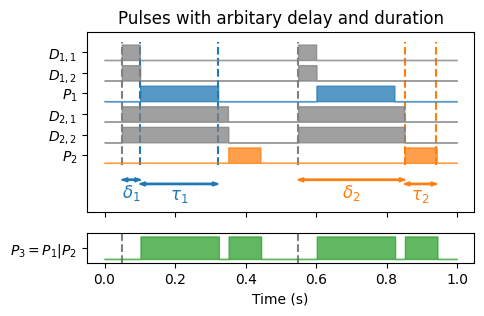

In [4]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 3), height_ratios=[6,1])
colors = ["gray", "gray",  "C0", "gray", "gray", "C1"]
labels = [r"$D_{1,1}$", r"$D_{1,2}$", r"$P_1$", r"$D_{2,1}$", r"$D_{2,2}$", r"$P_2$"]
plot_traces(steps, did_start[:,:-1], did_stop[:,:-1], ax=ax[0], colors=colors, labels=labels, alpha=0.75, zorder=10)
ax[0].vlines([steps[50], steps[550]], 0.5, 6.5, color="gray", linestyle="--")
ax[0].vlines([steps[51+p_start1], steps[51+p_end1]], 0.5, 6.5, color="C0", linestyle="--")
ax[0].vlines([steps[551+p_start2], steps[551+p_end2]], 0.5, 6.5, color="C1", linestyle="--")

ax[0].arrow(steps[50], -0.2, steps[51+p_start1]-steps[50], 0, color="C0", width=0.05, head_width=0.2, head_length=0.015, length_includes_head=True)
ax[0].arrow(steps[51+p_start1], -0.2, -steps[50], 0, color="C0", width=0.05, head_width=0.2, head_length=0.015, length_includes_head=True)
ax[0].text((steps[50]+steps[51+p_start1])/2, -0.3, r"$\delta_1$", color="C0", fontsize=12, ha="center", va="top")

ax[0].arrow(steps[51+p_start1], -0.4, steps[51+p_end1]-steps[51+p_start1], 0, color="C0", width=0.05, head_width=0.2, head_length=0.015, length_includes_head=True)
ax[0].arrow(steps[51+p_end1], -0.4, -(steps[51+p_end1]-steps[51+p_start1]), 0, color="C0", width=0.05, head_width=0.2, head_length=0.015, length_includes_head=True)
ax[0].text((steps[51+p_start1]+steps[51+p_end1])/2, -0.5, r"$\tau_1$", color="C0", fontsize=12, ha="center", va="top")

ax[0].arrow(steps[550], -0.2, steps[551+p_start2]-steps[550], 0, color="C1", width=0.05, head_width=0.2, head_length=0.015, length_includes_head=True)
ax[0].arrow(steps[551+p_start2], -0.2, -(steps[551+p_start2]-steps[550]), 0, color="C1", width=0.05, head_width=0.2, head_length=0.015, length_includes_head=True)
ax[0].text((steps[550]+steps[551+p_start2])/2, -0.3, r"$\delta_2$", color="C1", fontsize=12, ha="center", va="top")

ax[0].arrow(steps[551+p_start2], -0.4, steps[551+p_end2]-steps[551+p_start2], 0, color="C1", width=0.05, head_width=0.2, head_length=0.015, length_includes_head=True)
ax[0].arrow(steps[551+p_end2], -0.4, -(steps[551+p_end2]-steps[551+p_start2]), 0, color="C1", width=0.05, head_width=0.2, head_length=0.015, length_includes_head=True)
ax[0].text((steps[551+p_start2]+steps[551+p_end2])/2, -0.5, r"$\tau_2$", color="C1", fontsize=12, ha="center", va="top")

ax[0].set_title("Pulses with arbitary delay and duration")
ax[0].set_ylim(-1.75, 7)

plot_traces(steps, did_start[:,-1:], did_stop[:,-1:], ax=ax[1], colors=["C2"], labels=["$P_3=P_1|P_2$"], alpha=0.75, zorder=10)
ax[1].vlines([steps[50], steps[550]], 0.5, 6.5, color="gray", linestyle="--")
ax[1].set_ylim(0.5, 1.5)
ax[1].set_xlabel("Time (s)")

fig.savefig("pulses.png", dpi=300, bbox_inches="tight")
fig.savefig("pulses.svg", dpi=300, bbox_inches="tight")
fig.savefig("pulses.pdf", dpi=300, bbox_inches="tight")